# About

This notebook helps you to create your first solution and the first submisson file. Fill free to modify this notebook to create you own solution.

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from tqdm import tqdm
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

from scipy.spatial.distance import cdist, pdist

In [29]:
# Change this according to your directory preferred setting
path_to_train = "data/train_100_events"

# This event is in Train_1
event_prefix = "event000001000"

### Train

Lets combine several events into single sample to train the classifier.

In [30]:
def feature_importance(forest, X_train):
    ranked_list = []
    
    importances = forest.feature_importances_

    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + " - " + X_train.columns[indices[f]])
        ranked_list.append(X_train.columns[indices[f]])
    
    return ranked_list

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def get_training_sample(path_to_data, event_names):

    events = []
    track_id = 0

    for name in tqdm(event_names):
        # if there is an error skip it
        try:
            # Read an event
            hits, cells, particles, truth = load_event(os.path.join(path_to_data, name))

            # Generate new vector of particle id
            particle_ids = truth.particle_id.values
            particle2track = {}
            for pid in np.unique(particle_ids):
                particle2track[pid] = track_id
                track_id += 1
            hits['particle_id'] = [particle2track[pid] for pid in particle_ids]

            # Collect hits
            events.append(hits)
        except:
            print("Error with", name)
            continue
            
    # Put all hits into one sample with unique track ids
    data = pd.concat(events, axis=0)

    return data

In [37]:
start_event_id = 1000
n_train_samples = 1
train_event_names = ["event0000{:05d}".format(i) for i in range(start_event_id, start_event_id+n_train_samples)]
train_data = get_training_sample(path_to_train, train_event_names)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


In [38]:
train_data['size'] = train_data.groupby('particle_id')['particle_id'].transform('count')
train_data.loc[train_data.particle_id == 0, 'size'] = 1
train_data.loc[train_data['size'] > 20, 'size'] = 1
hit_count = train_data['size'].values

In [39]:
train_data[train_data.particle_id == 3556].hit_id.count()

11

In [42]:
#add some features
train_data['r'] = np.sqrt(train_data['x'].values**2+train_data['y'].values**2+train_data['z'].values**2)
train_data['rt'] = np.sqrt(train_data['x'].values**2+train_data['y'].values**2)
train_data['x2'] = train_data['x'] / train_data['r']
train_data['y2'] = train_data['y'] / train_data['r']
train_data['z2'] = train_data['z'] / train_data['r']
train_data['a0'] = np.arctan2(train_data['y'].values,train_data['x'].values)
train_data['a1'] = train_data['a0']+1*(train_data['rt']+(1)*train_data['rt']**2)/1000*(1/2)/180*math.pi
train_data['sina1'] = np.sin(train_data['a1'].values)
train_data['cosa1'] = np.cos(train_data['a1'].values)

In [46]:
dist_mat = cdist(train_data[['x2','y2','z2']], train_data[['x2','y2','z2']])

MemoryError: 

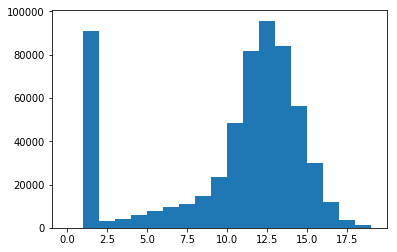

In [383]:
plt.hist(hit_count, bins=np.arange(0, 20, 1))
plt.show()

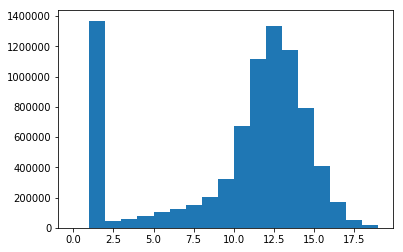

In [248]:
plt.hist(train_data['size'], bins=np.arange(0, 20, 1))
plt.show()

In [259]:
big_group_pids = hit_count[hit_count > 15]
big_group_filter = np.isin(train_data.particle_id, big_group_pids)
# big_groups = train_data[big_group_filter]
big_groups = train_data[train_data['size'] > 15]

small_group_pids = hit_count[hit_count <= 15]
small_group_filter = np.isin(train_data.particle_id, small_group_pids)
small_groups = train_data[train_data['size'] <= 15]

In [499]:
print("Groups > 15", len(big_group_pids))
print("Groups <= 15", len(small_group_pids))

Groups > 15 239967
Groups <= 15 7947772


In [520]:
et = ExtraTreesClassifier()
et.fit(train_data[features[:4]], train_data['size'])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [521]:
et.score(train_data[features[:4]], train_data['size'])

0.9997427727723265

In [523]:
features = feature_importance(et, train_data[features[:4]])
features

Feature ranking:
1. feature 0 (0.291826) - z2
2. feature 1 (0.244085) - x2
3. feature 2 (0.241520) - y2
4. feature 3 (0.222569) - a0


['z2', 'x2', 'y2', 'a0']

In [508]:
train_data.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,size,r,rt,x2,y2,z2,a0,a1,sina1,cosa1
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0,1,1503.896973,64.807045,-0.042829,-0.004763,-0.999071,-3.030827,-2.993610,-0.147443,-0.989071
1,2,-55.336102,0.635342,-1502.5,7,2,1,477,10,1503.518799,55.339748,-0.036804,0.000423,-0.999322,3.130112,3.157320,-0.015726,-0.999876
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0,1,1504.837158,83.838287,-0.055707,-0.000760,-0.998447,-3.127959,-3.065889,-0.075631,-0.997136
3,4,-96.109100,-8.241030,-1502.5,7,2,1,3556,11,1505.593262,96.461777,-0.063835,-0.005474,-0.997945,-3.056055,-2.974013,-0.166796,-0.985991
4,5,-62.673599,-9.371200,-1502.5,7,2,1,4811,10,1503.835815,63.370335,-0.041676,-0.006232,-0.999112,-2.993168,-2.957571,-0.182985,-0.983116


In [261]:
big_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x,y,z,x2,y2,z2,a0,a1,cosa1,sina1,size
count,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000
mean,2.360213,0.675520,8.516754,0.003211,0.002624,0.005120,-0.002746,0.981707,-0.005257,-0.004821,16.378198
std,237.583420,236.929886,1137.024658,0.313450,0.314875,0.895859,1.814825,2.663670,0.706655,0.707525,0.679998
min,-1025.290039,-1025.109985,-2955.500000,-0.999960,-0.999998,-0.999789,-3.141588,-3.132210,-1.000000,-1.000000,16.000000
25%,-59.642050,-61.499550,-702.500000,-0.086306,-0.089858,-0.988921,-1.568953,-1.033191,-0.714576,-0.714523,16.000000
50%,0.068255,-0.427959,0.746876,0.000104,-0.000617,0.008600,-0.008118,0.772311,-0.009020,-0.007890,16.000000
75%,61.730749,62.911699,711.400024,0.090502,0.093815,0.988258,1.571343,2.465490,0.695155,0.703696,17.000000
max,1025.170044,1025.219971,2955.500000,1.000000,0.999997,0.999785,3.141590,12.314260,1.000000,1.000000,20.000000


In [277]:
small_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x,y,z,x2,y2,z2,a0,a1,cosa1,sina1,size
count,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06
mean,7.686771e-01,-1.471646e-02,2.915401e-01,1.268735e-03,-2.092988e-04,-2.314794e-04,-1.312986e-03,1.687868e+00,4.849422e-04,8.071866e-04,9.593429e+00
std,3.102179e+02,3.114612e+02,1.062030e+03,3.872704e-01,3.885462e-01,8.360932e-01,1.811363e+00,3.104579e+00,7.069108e-01,7.073022e-01,4.555010e+00
min,-1.025330e+03,-1.025340e+03,-2.955500e+03,-9.999990e-01,-9.999994e-01,-9.997995e-01,-3.141593e+00,-3.133096e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
25%,-1.020530e+02,-1.032913e+02,-6.442000e+02,-1.796620e-01,-1.819155e-01,-9.306689e-01,-1.571245e+00,-6.269830e-01,-7.059760e-01,-7.071772e-01,8.000000e+00
50%,1.712210e-01,9.161160e-02,-1.281240e-01,2.985206e-04,1.576020e-04,-1.195998e-03,1.405130e-03,1.302153e+00,8.713165e-04,2.934773e-03,1.100000e+01
75%,1.034553e+02,1.034470e+02,6.426000e+02,1.816419e-01,1.820801e-01,9.302516e-01,1.567249e+00,3.093534e+00,7.074098e-01,7.078758e-01,1.300000e+01
max,1.025330e+03,1.025340e+03,2.955500e+03,9.999993e-01,9.999999e-01,9.997988e-01,3.141592e+00,1.231751e+01,1.000000e+00,1.000000e+00,1.500000e+01


In [278]:
big_groups[['x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x2,y2,z2,a0,a1,cosa1,sina1,size
count,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000,239967.000000
mean,0.003211,0.002624,0.005120,-0.002746,0.981707,-0.005257,-0.004821,16.378198
std,0.313450,0.314875,0.895859,1.814825,2.663670,0.706655,0.707525,0.679998
min,-0.999960,-0.999998,-0.999789,-3.141588,-3.132210,-1.000000,-1.000000,16.000000
25%,-0.086306,-0.089858,-0.988921,-1.568953,-1.033191,-0.714576,-0.714523,16.000000
50%,0.000104,-0.000617,0.008600,-0.008118,0.772311,-0.009020,-0.007890,16.000000
75%,0.090502,0.093815,0.988258,1.571343,2.465490,0.695155,0.703696,17.000000
max,1.000000,0.999997,0.999785,3.141590,12.314260,1.000000,1.000000,20.000000


In [279]:
small_groups[['x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1', 'size']].describe()

,x2,y2,z2,a0,a1,cosa1,sina1,size
count,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06,7.947772e+06
mean,1.268735e-03,-2.092988e-04,-2.314794e-04,-1.312986e-03,1.687868e+00,4.849422e-04,8.071866e-04,9.593429e+00
std,3.872704e-01,3.885462e-01,8.360932e-01,1.811363e+00,3.104579e+00,7.069108e-01,7.073022e-01,4.555010e+00
min,-9.999990e-01,-9.999994e-01,-9.997995e-01,-3.141593e+00,-3.133096e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
25%,-1.796620e-01,-1.819155e-01,-9.306689e-01,-1.571245e+00,-6.269830e-01,-7.059760e-01,-7.071772e-01,8.000000e+00
50%,2.985206e-04,1.576020e-04,-1.195998e-03,1.405130e-03,1.302153e+00,8.713165e-04,2.934773e-03,1.100000e+01
75%,1.816419e-01,1.820801e-01,9.302516e-01,1.567249e+00,3.093534e+00,7.074098e-01,7.078758e-01,1.300000e+01
max,9.999993e-01,9.999999e-01,9.997988e-01,3.141592e+00,1.231751e+01,1.000000e+00,1.000000e+00,1.500000e+01


In [493]:
big_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1']].describe() - small_groups[['x', 'y', 'z', 'x2', 'y2', 'z2', 'a0', 'a1', 'cosa1', 'sina1']].describe()

,x,y,z,x2,y2,z2,a0,a1,cosa1,sina1
count,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06,-7.707805e+06
mean,1.591536e+00,6.902363e-01,8.225214e+00,1.942499e-03,2.833414e-03,5.351401e-03,-1.433142e-03,-7.061611e-01,-5.741805e-03,-5.627812e-03
std,-7.263448e+01,-7.453130e+01,7.499487e+01,-7.382038e-02,-7.367092e-02,5.976576e-02,3.461838e-03,-4.409089e-01,-2.558827e-04,2.232194e-04
min,3.991699e-02,2.299805e-01,0.000000e+00,3.868341e-05,1.609325e-06,1.001358e-05,4.768372e-06,8.857250e-04,0.000000e+00,0.000000e+00
25%,4.241095e+01,4.179170e+01,-5.829999e+01,9.335582e-02,9.205753e-02,-5.825190e-02,2.291977e-03,-4.062083e-01,-8.600459e-03,-7.345527e-03
50%,-1.029660e-01,-5.195706e-01,8.750000e-01,-1.943364e-04,-7.746176e-04,9.796068e-03,-9.523390e-03,-5.298418e-01,-9.890971e-03,-1.082476e-02
75%,-4.172450e+01,-4.053530e+01,6.880005e+01,-9.114030e-02,-8.826520e-02,5.800669e-02,4.093230e-03,-6.280442e-01,-1.225471e-02,-4.180267e-03
max,-1.599121e-01,-1.199951e-01,0.000000e+00,2.384186e-07,-3.039837e-06,-1.364946e-05,-1.668930e-06,-3.249168e-03,0.000000e+00,0.000000e+00


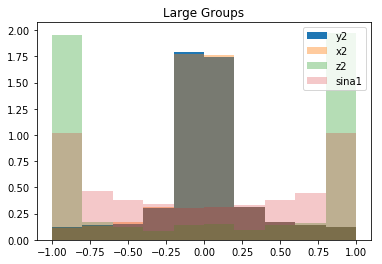

In [270]:
plt.hist(big_groups['y2'], label="y2", normed=True)
plt.hist(big_groups['x2'], label="x2", normed=True, alpha=0.4)
plt.hist(big_groups['z2'], label="z2", normed=True, alpha=0.35)
plt.hist(big_groups['sina1'], label="sina1", normed=True, alpha=0.25)
plt.legend()
plt.title("Large Groups")
plt.show()

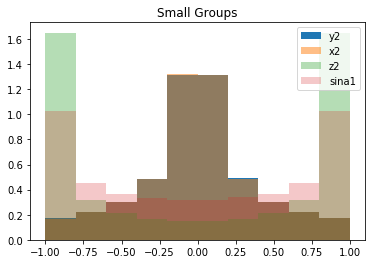

In [269]:
plt.hist(small_groups['y2'], label="y2", normed=True)
plt.hist(small_groups['x2'], label="x2", normed=True, alpha=0.5)
plt.hist(small_groups['z2'], label="z2", normed=True, alpha=0.35)
plt.hist(small_groups['sina1'], label="sina1", normed=True, alpha=0.25)
plt.title("Small Groups")
plt.legend()
plt.show()

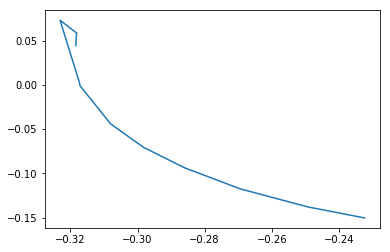

In [373]:
p_id = 49909    
# p_id = 1110
# p_id = 10
plt.plot(train_data[train_data.particle_id == p_id].sort_values("y").x2, train_data[train_data.particle_id == p_id].sort_values("y").y2)

In [486]:
p_id = 49909
train_data[train_data.particle_id == p_id].describe()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,size,r,rt,x2,y2,z2,a0,a1,sina1,cosa1
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,88437.125000,-354.053528,-113.750458,1219.097900,12.437500,5.125000,251.500000,49909.0,16.0,1277.207520,380.414062,-0.296513,-0.033484,0.950953,-0.266665,1.608814,-0.057353,-0.337260
std,38756.542825,239.425919,154.914490,927.108154,3.424787,3.095696,295.250854,0.0,0.0,966.247681,272.898102,0.028436,0.079102,0.005044,2.989415,2.051060,0.572278,0.783791
min,27744.000000,-712.752014,-461.091003,92.232697,8.000000,2.000000,6.000000,49909.0,16.0,97.750847,32.378353,-0.323096,-0.150324,0.943549,-3.135297,-2.516158,-0.999571,-0.999767
25%,43075.750000,-554.816742,-199.647755,308.051006,8.000000,2.000000,9.750000,49909.0,16.0,325.359795,104.706760,-0.318133,-0.100253,0.946751,-2.822828,-0.012757,-0.554178,-0.980715
50%,100669.000000,-330.877991,-29.175114,1008.549988,13.500000,4.000000,78.500000,49909.0,16.0,1062.075623,332.898773,-0.312475,-0.023046,0.949402,-2.601758,2.643789,0.005331,-0.821264
75%,115262.750000,-103.584148,8.582200,1885.250000,14.000000,6.500000,419.750000,49909.0,16.0,1975.479614,590.178070,-0.281417,0.047755,0.954251,2.959742,3.036551,0.156115,0.475738
max,138094.000000,-31.582899,15.877800,2947.500000,18.000000,12.000000,760.000000,49909.0,16.0,3067.307617,848.893616,-0.232371,0.072970,0.960940,3.141360,3.730013,0.880129,0.999940


In [489]:
train_data.groupby("particle_id").z2.std().describe()

count    4.723000e+04
mean     3.955753e-02
std      1.109142e-01
min      4.214685e-08
25%      1.382688e-04
50%      3.418009e-03
75%      2.620135e-02
max      1.381344e+00
Name: z2, dtype: float64

In [492]:
7e-8 * 250

1.7500000000000002e-05

In [485]:
min_points = 2
num_loops = 200
min_points_change = 0.5

min_pts_change = ((15 - min_points) / num_loops) * min_points_change
min_pts_change * 200

6.5

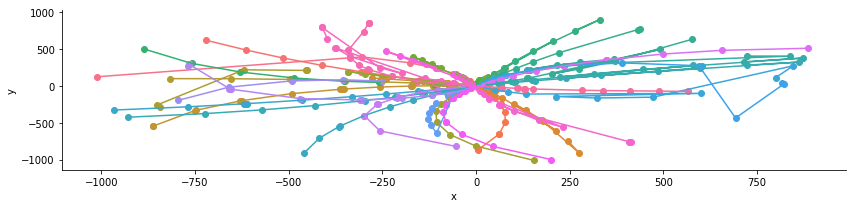

In [475]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'y')
fg.map(plt.plot, 'x', 'y')

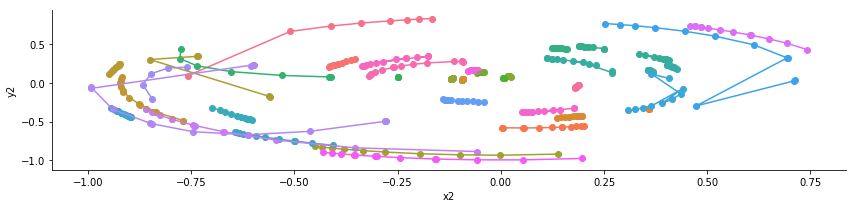

In [47]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

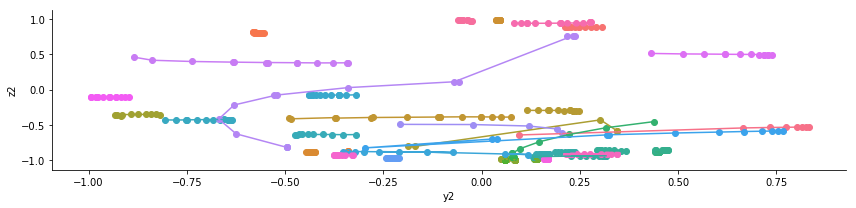

In [51]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'y2', 'z2')
fg.map(plt.plot, 'y2', 'z2')

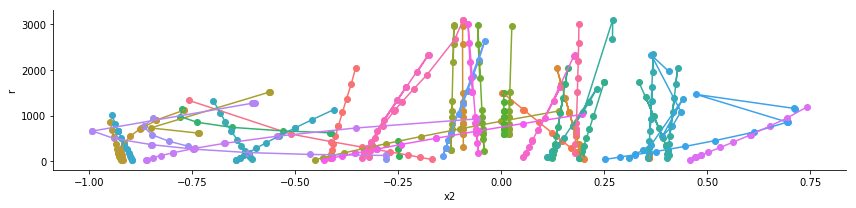

In [340]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'r')
fg.map(plt.plot, 'x2', 'r')

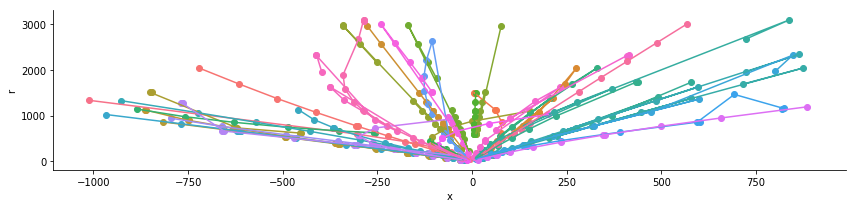

In [369]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'r')
fg.map(plt.plot, 'x', 'r')

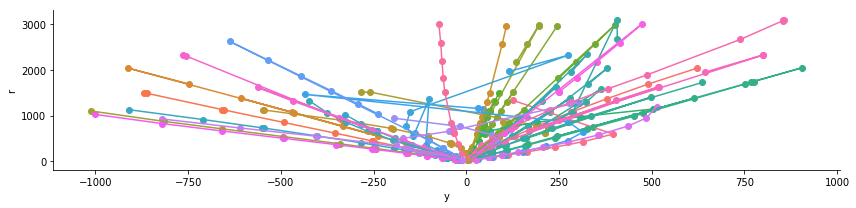

In [370]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'y', 'r')
fg.map(plt.plot, 'y', 'r')

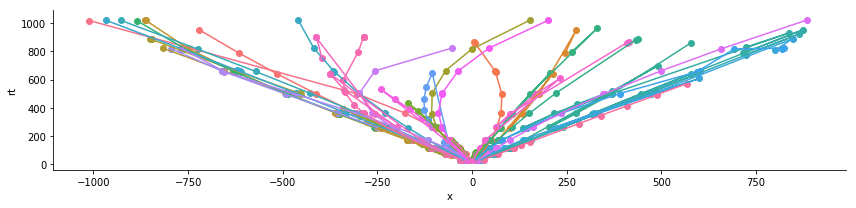

In [344]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'rt')
fg.map(plt.plot, 'x', 'rt')

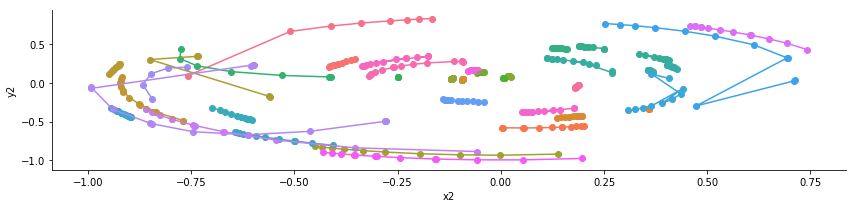

In [346]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

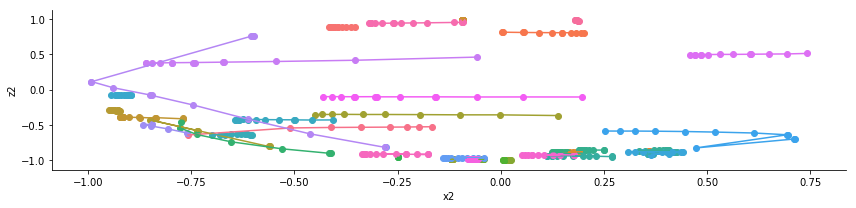

In [487]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'z2')
fg.map(plt.plot, 'x2', 'z2')

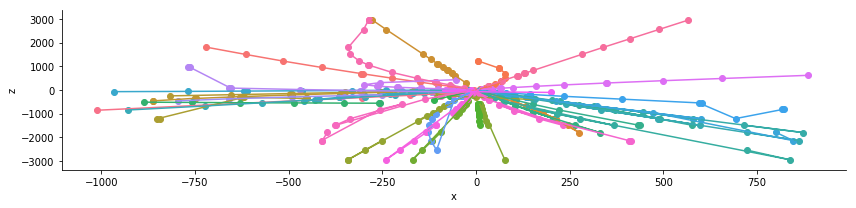

In [488]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'z')
fg.map(plt.plot, 'x', 'z')

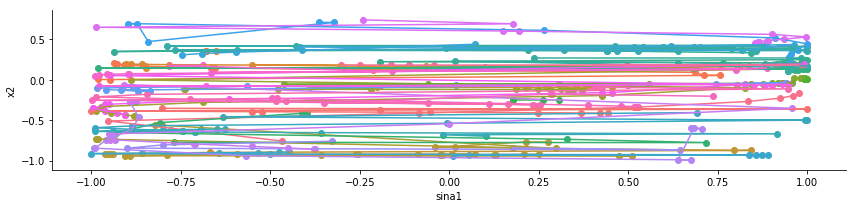

In [494]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'sina1', 'x2')
fg.map(plt.plot, 'sina1', 'x2')

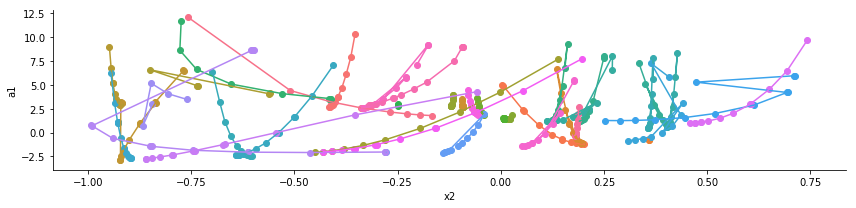

In [498]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'a1')
fg.map(plt.plot, 'x2', 'a1')

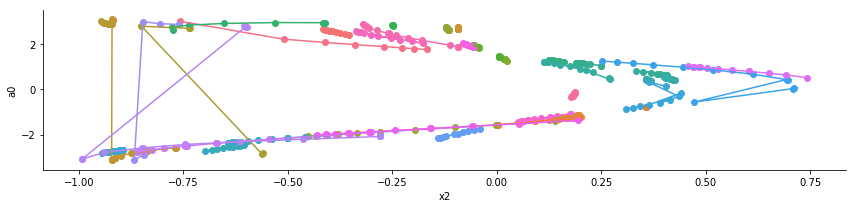

In [497]:
fg = sns.FacetGrid(data=train_data[(train_data.particle_id < 40) & (train_data['size'].values > 1)], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'a0')
fg.map(plt.plot, 'x2', 'a0')

## Polynomial Linear Model

In [469]:
subset = train_data[train_data['size'] == 15][['x', 'y', 'z', 'particle_id']]
targets = subset.particle_id
x2 = subset.x
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(subset.drop(["particle_id", "x"], axis=1).dropna())

In [470]:
X.shape

(29850, 6)

In [471]:
subset.shape

(29850, 4)

In [472]:
pids = subset.particle_id.unique()
len(pids)

1990

In [473]:
scores = []
for pid in pids[9:]:
    idx = subset.particle_id == pid
    lm = LinearRegression()
    lm.fit(X[idx], y[idx])
    score = lm.score(X[idx], x2[idx])
    preds = lm.predict(X[idx])
    print(score)
    break

-10.42909874392334


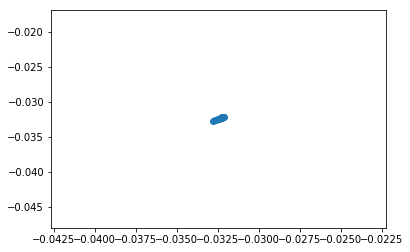

In [474]:
plt.scatter(y[idx], preds)

In [468]:
lm.coef_

array([ 0.00000000e+00,  3.68102941e-03, -1.61088745e-04,  6.76825811e-02,
       -5.73803112e-03,  1.21606586e-04,  4.17589404e-02, -5.25803692e-03,
        2.20658730e-04, -3.08632246e-06])

Then, train the classifier using this sample. Notice that data preprocessing is included into the training procedure.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

class Clusterer(object):
    
    def __init__(self):
        self.classifier = None
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    def fit(self, hits):
        
        X = self._preprocess(hits)
        y = hits.particle_id.values
        
        self.classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
        self.classifier.fit(X, y)
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        labels = self.classifier.predict(X)
        
        return labels

In [7]:
model = Clusterer()
model.fit(train_data)

### Test

Use the trained classifier to predict labels of hits in a new event.

In [8]:
path_to_event = os.path.join(path_to_train, "event0000{:05d}".format(start_event_id + n_train_samples + 1))
hits, cells, particles, truth = load_event(path_to_event)

In [9]:
%%time
# Warning: it takes about 30s per one event
labels = model.predict(hits)

CPU times: user 23.4 s, sys: 10.6 ms, total: 23.4 s
Wall time: 19 s


# Score

Calculate quality of the track pattern recognition for one event.

In [10]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [11]:
print("Your score: ", score)

Your score:  0.09900948072230796


# Recognize tracks in all events of a dataset

In this example, the dataset is the whole training set. This may take a very long time. To run on only a subset, use

     load_dataset(path_to_train, skip=1000, nevents=5)

It will skip the first 1000 events, and select the next 5 ones.

**Warning:** it takes about 30s per one event

In [33]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=5):
        
    # Track pattern recognition
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

Score for event 1010: 0.065
Score for event 1011: 0.068
Score for event 1012: 0.065
Score for event 1013: 0.078
Score for event 1014: 0.086
Mean score: 0.073


# Submission

Create a submission file.

**Warning:** it takes about 30s per one event

In [ ]:
path_to_test = "data/test"
test_dataset_submissions = []

create_submission = True

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('20180626_submission_3.csv.gz', index=False, compression='gzip')

Event ID:  0
Event ID:  1
Event ID:  2
Event ID:  3
Event ID:  4
Event ID:  5
Event ID:  6
Event ID:  7
Event ID:  8
Event ID:  9
Event ID:  10
Event ID:  11
Event ID:  12
Event ID:  13
Event ID:  14
Event ID:  15
Event ID:  16
Event ID:  17
Event ID:  18
Event ID:  19
Event ID:  20
Event ID:  21
Event ID:  22
Event ID:  23
Event ID:  24
Event ID:  25
Event ID:  26
Event ID:  27
Event ID:  28
Event ID:  29
Event ID:  30
Event ID:  31
Event ID:  32
Event ID:  33
Event ID:  34
Event ID:  35
Event ID:  36
Event ID:  37
Event ID:  38
Event ID:  39
Event ID:  40
Event ID:  41
Event ID:  42
Event ID:  43
Event ID:  44
Event ID:  45
Event ID:  46
Event ID:  47
Event ID:  48
Event ID:  49
